### Appliquer word2vec à des données non textuelles 

Word2vec exploite la nature séquentielle du texte pour créer un word embedding. 

Cette propriété même m'a fait réfléchir à des données autres que du texte qui ont également une nature séquentielle.

L'une de ces données concerne les achats effectués par les consommateurs sur les sites e-commerce. La plupart du temps, il existe un modèle dans le comportement d'achat des consommateurs.


Si nous pouvons représenter chacun de ces produits par un vecteur, alors nous pouvons facilement trouver des produits similaires. Ainsi, si un utilisateur vérifie un produit en ligne, nous pouvons facilement lui recommander des produits similaires en utilisant le score de similitude vectorielle entre les produits.

Imaginez simplement l'historique d'achat d'un consommateur comme une phrase et les produits comme ses mots:

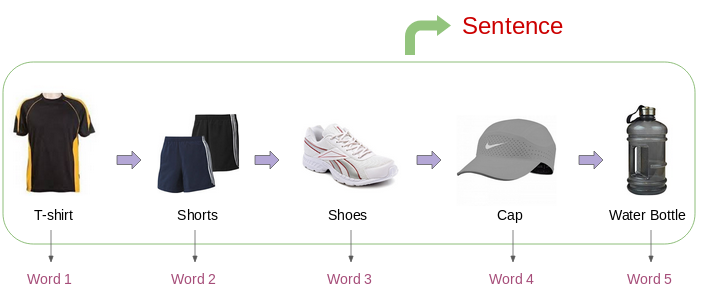

> Dans cette atelier, nous allons travailler sur des données d'achat en ligne en essayant de construire un système de recommandation à base de contenu en utilisant word2vec.

## Importer les librairies 

In [1]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings;
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('Online Retail.xlsx')

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Ci-dessous la description de chaque champ dans le dataset:

1. __InvoiceNo:__ Invoice number, a unique number assigned to each transaction.

2. __StockCode:__ Product/item code. a unique number assigned to each distinct product.

3. __Description:__ Product description

4. __Quantity:__ The quantities of each product per transaction.

5. __InvoiceDate:__ Invoice Date and time. The day and time when each transaction was generated.

6. __CustomerID:__ Customer number, a unique number assigned to each customer.

In [4]:
df.shape

(541909, 8)

la dataset contient 541,909 trasactions

## Traiter les données manquantes 

In [5]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

<br>
Puisque nous avons suffisamment de données nous allons supprimer les données manquantes 

In [6]:

df.dropna(inplace=True)

# s'assuer qu'il n'existe plus de données manquantes 
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

## La préparation de données 

on va convertir StockCode en string

In [7]:
df['StockCode']= df['StockCode'].astype(str)

Le nombre des cleints (cutomers) unique dans notre dataset 

In [8]:
customers = df["CustomerID"].unique().tolist()
len(customers)

4372

Il y a 4 372 clients dans notre dataset. Pour chacun de ces clients, nous extrairons leur historique d'achat. En d'autres termes, nous pouvons avoir 4 372 séquences d'achats.

Il est recommandé de réserver une petite partie de l'ensemble de données à des fins de validation. Par conséquent, nous reserverons 90% des clients pour créer des prolongement word2vec. Divisons les données.

In [9]:
# mélonger les customer Id
random.shuffle(customers)

# extraire 90% des customer ID
customers_train = [customers[i] for i in range(round(0.9*len(customers)))]

# diviser les données en training et validation ou test
train_df = df[df['CustomerID'].isin(customers_train)]
validation_df = df[~df['CustomerID'].isin(customers_train)]

In [10]:
len(train_df)+len(validation_df)

406829

Créons des séquences d'achats effectués par les clients dans l'ensemble de données pour le train et la validation.

In [11]:
# liste pour stocker l'historique d'achat pour chaque client (les produits achetés )
purchases_train = []

# ajouter les codes des produits à la liste 
for i in tqdm(customers_train):
    temp = train_df[train_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_train.append(temp)

100%|█████████████████████████████████████████████████████████████████████████████| 3935/3935 [00:07<00:00, 496.07it/s]


In [12]:
# liste pour stocker l'historique d'achat pour chaque client (les produits achetés )
purchases_val = []

# ajouter les codes des produits à la liste 
for i in tqdm(validation_df['CustomerID'].unique()):
    temp = validation_df[validation_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_val.append(temp)

100%|███████████████████████████████████████████████████████████████████████████████| 437/437 [00:00<00:00, 613.11it/s]


## Build word2vec Embeddings for Products

In [13]:
# Entrainer le modèle word2vec 
model = Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(purchases_train, progress_per=200)

model.train(purchases_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

(3573340, 3610560)

In [14]:
# sauvegarder le model
model.save("word2vec_2.model")

As we do not plan to train the model any further, we are calling init_sims(), which will make the model much more memory-efficient.

In [15]:
model.init_sims(replace=True)

In [16]:
print(model)

Word2Vec(vocab=3169, vector_size=100, alpha=0.03)


In [17]:
# extraire les vecteurs  
#X = model[model.wv.vocab]
X = model.wv.index_to_key
#X.shape

## réalisons la recommandation 

Maintenant, notre prochaine étape consiste à suggérer des produits similaires pour un certain produit ou un vecteur de produit.

Commençons par créer un dictionnaire d'ID de produit et de description de produit pour mapper facilement la description d'un produit à son ID et vice versa.

In [18]:
products = train_df[["StockCode", "Description"]]

# supprimons les doublons 
products.drop_duplicates(inplace=True, subset='StockCode', keep="last")

# créons un dictionnaire product-ID et product-description
products_dict = products.groupby('StockCode')['Description'].apply(list).to_dict()

In [19]:
# testons le dictionnaire 
products_dict['84029E']

['RED WOOLLY HOTTIE WHITE HEART.']

<br>

cette fonction prendra le vecteur d'un produit (n) comme entrée et renverra les 6 produits similaires.

In [20]:
def similar_products(v, n = 6):
    
    # extraire les produits similaires pour le vecteur d'entrée
    ms = model.wv.similar_by_vector(v, topn= n+1)[1:]
    #print(ms)
    
    # extraire le nom et le score de similitude des produits similaires
    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms        

nous sllons lui passer le vecteur du produit '90019A' ('SILVER M.O.P ORBIT BRACELET')

In [21]:
similar_products(model.wv['90019A'])

[('SILVER M.O.P ORBIT DROP EARRINGS', 0.7864425182342529),
 ('AMBER DROP EARRINGS W LONG BEADS', 0.7756372094154358),
 ('WHITE VINT ART DECO CRYSTAL NECKLAC', 0.744080662727356),
 ('JADE DROP EARRINGS W FILIGREE', 0.7384073734283447),
 ('PINK BOUDICCA LARGE BRACELET', 0.7348017692565918),
 ('SILVER M.O.P. ORBIT NECKLACE', 0.7338614463806152)]

<br>

Que faire si nous voulons recommander des produits à un utilisateur en fonction des multiples achats qu'il a effectués dans le passé?

Une solution simple consiste à faire la moyenne de tous les vecteurs des produits qu'il a achetés jusqu'à présent et à utiliser ce vecteur résultant pour trouver des produits similaires. Pour cela, nous utiliserons la fonction ci-dessous qui prend une liste d'identifiants de produits et donne un vecteur à 100 dimensions qui est la moyenne des vecteurs des produits dans la liste d'entrée.

In [22]:
def aggregate_vectors(products):
    product_vec = []
    for i in products:
        try:
            product_vec.append(model.wv[i])
        except KeyError:
            continue
        
    return np.mean(product_vec, axis=0)

nous avons déjà créé une liste distincte de séquences d'achat à des fins de validation. Maintenant, utilisons cela.

In [23]:
len(purchases_val[0])

6

Nous passerons la séquence de l'ensemble de validation de ce produit à la fonction * aggregate_vectors *.

In [24]:
aggregate_vectors(purchases_val[0]).shape

(100,)

la fonction a renvoyé un tableau de 100 dimensions. Cela signifie que la fonction fonctionne correctement. Nous pouvons maintenant utiliser ce résultat pour obtenir les produits les plus similaires. 

In [25]:
similar_products(aggregate_vectors(purchases_val[0]))

[('VICTORIAN SEWING BOX SMALL ', 0.6241134405136108),
 ('VICTORIAN SEWING BOX MEDIUM', 0.6056064367294312),
 ('12 EGG HOUSE PAINTED WOOD', 0.48450011014938354),
 ('SHOE SHINE BOX ', 0.4590124487876892),
 ('ELEPHANT CARNIVAL POUFFE', 0.4579648971557617),
 ('LARGE POPCORN HOLDER ', 0.4526541531085968)]

En fait, notre système a recommandé 6 produits en fonction de l'historique complet des achats d'un utilisateur. De plus, si vous souhaitez obtenir des suggestions de produits en fonction des derniers achats uniquement, vous pouvez également utiliser le même ensemble de fonctions.

Ci-dessous, je ne donne que les 10 derniers produits achetés en entrée.

In [26]:
similar_products(aggregate_vectors(purchases_val[0][-10:]))

[('VICTORIAN SEWING BOX SMALL ', 0.6241134405136108),
 ('VICTORIAN SEWING BOX MEDIUM', 0.6056064367294312),
 ('12 EGG HOUSE PAINTED WOOD', 0.48450011014938354),
 ('SHOE SHINE BOX ', 0.4590124487876892),
 ('ELEPHANT CARNIVAL POUFFE', 0.4579648971557617),
 ('LARGE POPCORN HOLDER ', 0.4526541531085968)]